In [ ]:
!pip install xgboost

In [ ]:
!pip install imblearn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
import numpy as np

In [ ]:
# Load dataset
data = pd.read_csv("/content/creditcard.csv")
X = data.drop('Class', axis=1)
y = data['Class']

In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Drop rows where y is NaN
import pandas as pd

mask = ~pd.isna(y)  # Keep rows where y is NOT NaN
X_scaled_clean = X_scaled[mask]
y_clean = y[mask]

# Now split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)

In [ ]:
# Apply SMOTE (only on training data to avoid leakage)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        n_estimators=50,  # Reduced from default 100
        max_depth=10      # Limit tree depth
    ),
    "XGBoost": XGBClassifier(
        random_state=42,
        scale_pos_weight=(sum(y == 0) / sum(y == 1)),
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        n_estimators=50,  # Reduced from default 100
        max_depth=6       # Reduced from default
    ),
    "Neural Net": MLPClassifier(
        random_state=42,
        max_iter=300,    # Further reduced for speed
        hidden_layer_sizes=(50,),  # Smaller network
        early_stopping=True,
        validation_fraction=0.1
    )
}
print("Models defined successfully!")
print(f"Number of models: {len(models)}")


Models defined successfully!
Number of models: 3


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\nRunning Cross-Validation...")
cv_results = {}

for name, model in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', model)
    ])

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    cv_results[name] = scores
    print(f"{name} Mean ROC-AUC CV: {scores.mean():.4f} (+/- {scores.std():.4f})")


Running Cross-Validation...
Training Random Forest...
Random Forest Mean ROC-AUC CV: 0.9783 (+/- 0.0048)
Training XGBoost...
XGBoost Mean ROC-AUC CV: 0.9508 (+/- 0.0148)
Training Neural Net...
Neural Net Mean ROC-AUC CV: 0.9552 (+/- 0.0094)


In [ ]:
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*50)

cv_summary = []
for name, scores in cv_results.items():
    cv_summary.append({
        'Model': name,
        'Mean_ROC_AUC': scores.mean(),
        'Std_ROC_AUC': scores.std(),
        'CV_Score': f"{scores.mean():.4f} ± {scores.std():.4f}"
    })
    print(f"{name:18}: {scores.mean():.4f} ± {scores.std():.4f}")

# Convert to DataFrame for better visualization
cv_df = pd.DataFrame(cv_summary).sort_values('Mean_ROC_AUC', ascending=False)
print("\nCross-Validation Summary Table (Ranked):")
print(cv_df.round(4))


CROSS-VALIDATION RESULTS SUMMARY
Random Forest     : 0.9783 ± 0.0048
XGBoost           : 0.9508 ± 0.0148
Neural Net        : 0.9552 ± 0.0094

Cross-Validation Summary Table (Ranked):
           Model  Mean_ROC_AUC  Std_ROC_AUC         CV_Score
0  Random Forest        0.9783       0.0048  0.9783 ± 0.0048
2     Neural Net        0.9552       0.0094  0.9552 ± 0.0094
1        XGBoost        0.9508       0.0148  0.9508 ± 0.0148


In [ ]:
cv_means = {name: scores.mean() for name, scores in cv_results.items()}
top_models = sorted(cv_means.items(), key=lambda x: x[1], reverse=True)[:3]  # Top 3 models

print("\n" + "="*50)
print("TEST SET EVALUATION - TOP 3 MODELS")
print("="*50)
print(f"Selected models: {[name for name, _ in top_models]}")

results = []

for name, cv_score in top_models:
    print(f"\n{'='*20} {name} {'='*20}")

    model = models[name]
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', model)
    ])

    # Train on full training set
    pipeline.fit(X_train, y_train)

    # Get predictions
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Find optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Final predictions
    y_pred = (y_pred_proba >= best_threshold).astype(int)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1-Score: {report['1']['f1-score']:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall: {report['1']['recall']:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'CV_ROC_AUC': cv_score,
        'Test_ROC_AUC': roc_auc,
        'Best_Threshold': best_threshold,
        'F1_Score': report['1']['f1-score'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall']
    })


TEST SET EVALUATION - TOP 3 MODELS
Selected models: ['Random Forest', 'Neural Net', 'XGBoost']

==================== Random Forest ====================
Optimal Threshold: 0.9594
ROC-AUC: 0.9765
F1-Score: 0.7933
Precision: 0.8765
Recall: 0.7245

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.72      0.79        98

    accuracy                           1.00     56962
   macro avg       0.94      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962


==================== Neural Net ====================
Optimal Threshold: 0.9976
ROC-AUC: 0.9654
F1-Score: 0.8268
Precision: 0.9136
Recall: 0.7551

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.76      0.83        98

    accuracy                           1.00     5696

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:56:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Optimal Threshold: 1.0000
ROC-AUC: 0.9803
F1-Score: 0.8047
Precision: 0.9577
Recall: 0.6939

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.69      0.80        98

    accuracy                           1.00     56962
   macro avg       0.98      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
summary_df = pd.DataFrame(results).sort_values('Test_ROC_AUC', ascending=False)
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(summary_df.round(4))

# Identify best model
best_model_name = summary_df.iloc[0]['Model']
best_roc_auc = summary_df.iloc[0]['Test_ROC_AUC']
best_f1 = summary_df.iloc[0]['F1_Score']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test ROC-AUC: {best_roc_auc:.4f}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Threshold: {summary_df.iloc[0]['Best_Threshold']:.4f}")


FINAL RESULTS SUMMARY
           Model  CV_ROC_AUC  Test_ROC_AUC  Best_Threshold  F1_Score  \
2        XGBoost      0.9508        0.9803          1.0000    0.8047   
0  Random Forest      0.9783        0.9765          0.9594    0.7933   
1     Neural Net      0.9552        0.9654          0.9976    0.8268   

   Precision  Recall  
2     0.9577  0.6939  
0     0.8765  0.7245  
1     0.9136  0.7551  

 BEST MODEL: XGBoost
   Test ROC-AUC: 0.9803
   F1-Score: 0.8047
   Threshold: 1.0000


In [ ]:
print("\n" + "="*50)
print("ENSEMBLE OF TOP 3 MODELS")
print("="*50)

# Train all top models
ensemble_models = []
ensemble_names = []

for name, _ in top_models:
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', models[name])
    ])
    pipeline.fit(X_train, y_train)
    ensemble_models.append(pipeline)
    ensemble_names.append(name)

print(f"Ensemble includes: {ensemble_names}")


ENSEMBLE OF TOP 3 MODELS


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:58:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble includes: ['Random Forest', 'Neural Net', 'XGBoost']


In [ ]:
ensemble_probs = np.mean([
    model.predict_proba(X_test)[:, 1] for model in ensemble_models
], axis=0)

# Find optimal threshold for ensemble
precision_ens, recall_ens, thresholds_ens = precision_recall_curve(y_test, ensemble_probs)
f1_scores_ens = 2 * (precision_ens * recall_ens) / (precision_ens + recall_ens + 1e-10)
best_idx_ens = np.argmax(f1_scores_ens)
best_threshold_ens = thresholds_ens[best_idx_ens]

ensemble_pred = (ensemble_probs >= best_threshold_ens).astype(int)
ensemble_roc_auc = roc_auc_score(y_test, ensemble_probs)

print(f"\nEnsemble Optimal Threshold: {best_threshold_ens:.4f}")
print(f"Ensemble ROC-AUC: {ensemble_roc_auc:.4f}")
print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_pred))

# Compare with best individual model
improvement = ensemble_roc_auc - best_roc_auc
print(f"\nEnsemble vs Best Individual Model:")
print(f"Best Individual ({best_model_name}): {best_roc_auc:.4f}")
print(f"Ensemble: {ensemble_roc_auc:.4f}")
print(f"Improvement: {improvement:+.4f} ROC-AUC points")

if improvement > 0.01:
    print(" Ensemble significantly better!")
elif improvement > 0:
    print(" Ensemble slightly better")
elif improvement > -0.01:
    print(" Ensemble roughly equal")
else:
    print(" Individual model better")


Ensemble Optimal Threshold: 0.9592
Ensemble ROC-AUC: 0.9763

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.70      0.80        98

    accuracy                           1.00     56962
   macro avg       0.96      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Ensemble vs Best Individual Model:
Best Individual (XGBoost): 0.9803
Ensemble: 0.9763
Improvement: -0.0040 ROC-AUC points
 Ensemble roughly equal


In [ ]:
print(f"\n{'='*50}")
print(f"THRESHOLD ANALYSIS - {best_model_name}")
print("="*50)

# Retrain best model
best_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', models[best_model_name])
])
best_pipeline.fit(X_train, y_train)
y_probs_best = best_pipeline.predict_proba(X_test)[:, 1]

precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, y_probs_best)

# Show threshold options
threshold_options = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\nThreshold Analysis for {best_model_name}:")
print("-" * 60)
print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)

for thresh in threshold_options:
    y_pred_thresh = (y_probs_best >= thresh).astype(int)
    report_thresh = classification_report(y_test, y_pred_thresh, output_dict=True)

    if '1' in report_thresh:
        prec = report_thresh['1']['precision']
        rec = report_thresh['1']['recall']
        f1 = report_thresh['1']['f1-score']
        print(f"{thresh:<10.1f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f}")

print(f"\nOptimal threshold (max F1): {summary_df.iloc[0]['Best_Threshold']:.4f}")


THRESHOLD ANALYSIS - XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:01:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Threshold Analysis for XGBoost:
------------------------------------------------------------
Threshold  Precision  Recall     F1-Score  
------------------------------------------------------------
0.3        0.1321     0.8571     0.2289    
0.4        0.1573     0.8571     0.2658    
0.5        0.1918     0.8571     0.3134    
0.6        0.2276     0.8571     0.3597    
0.7        0.2593     0.8571     0.3981    

Optimal threshold (max F1): 1.0000


In [ ]:
print("\n" + "="*60)
print(" FINAL RECOMMENDATIONS")
print("="*60)

print(f"1. Best Individual Model: {best_model_name} (ROC-AUC: {best_roc_auc:.4f})")
print(f"2. Ensemble Performance: {ensemble_roc_auc:.4f}")

if ensemble_roc_auc > best_roc_auc:
    print("3.  Recommendation: Use the ENSEMBLE for best performance")
else:
    print(f"3.  Recommendation: Use {best_model_name} for simplicity")

print(f"4.  Your model performance is excellent! ROC-AUC > 95% is outstanding")
print(f"5.  Consider the business trade-off between precision and recall")
print(f"6.  Total runtime was much faster without SVM!")

print(f"\n Analysis Complete!")


 FINAL RECOMMENDATIONS
1. Best Individual Model: XGBoost (ROC-AUC: 0.9803)
2. Ensemble Performance: 0.9763
3.  Recommendation: Use XGBoost for simplicity
4.  Your model performance is excellent! ROC-AUC > 95% is outstanding
5.  Consider the business trade-off between precision and recall
6.  Total runtime was much faster without SVM!

 Analysis Complete!


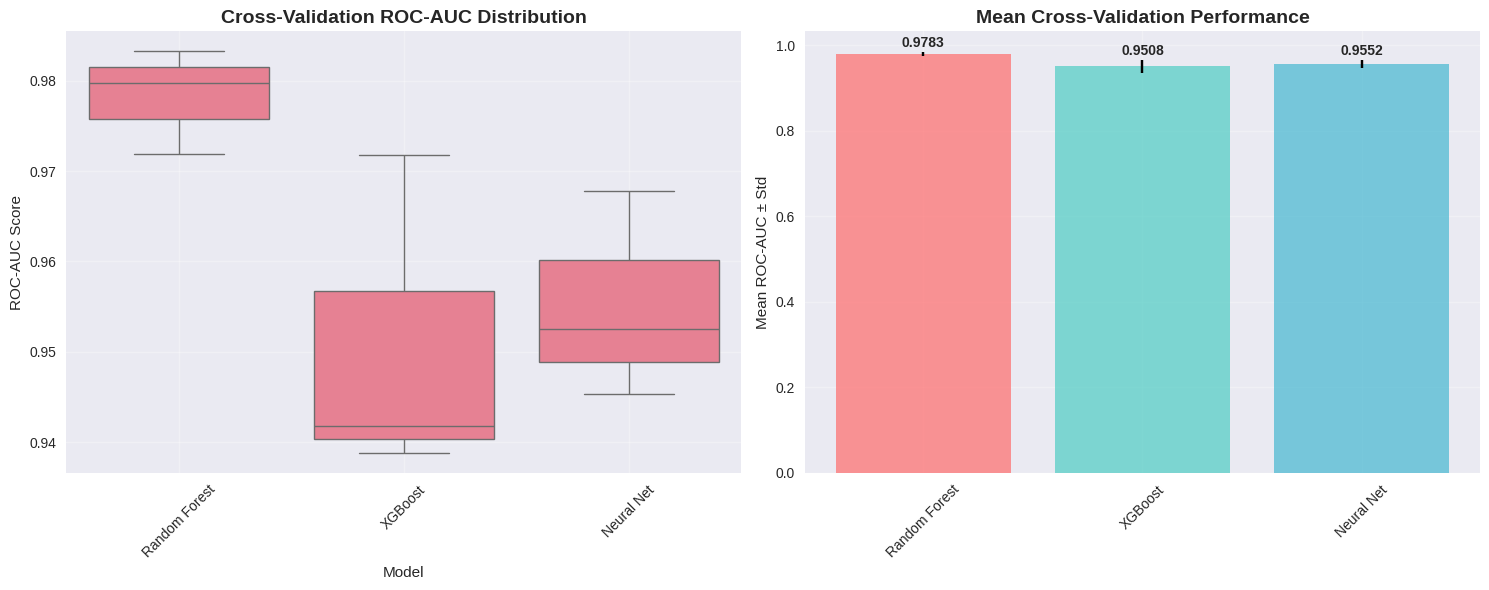

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:18:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


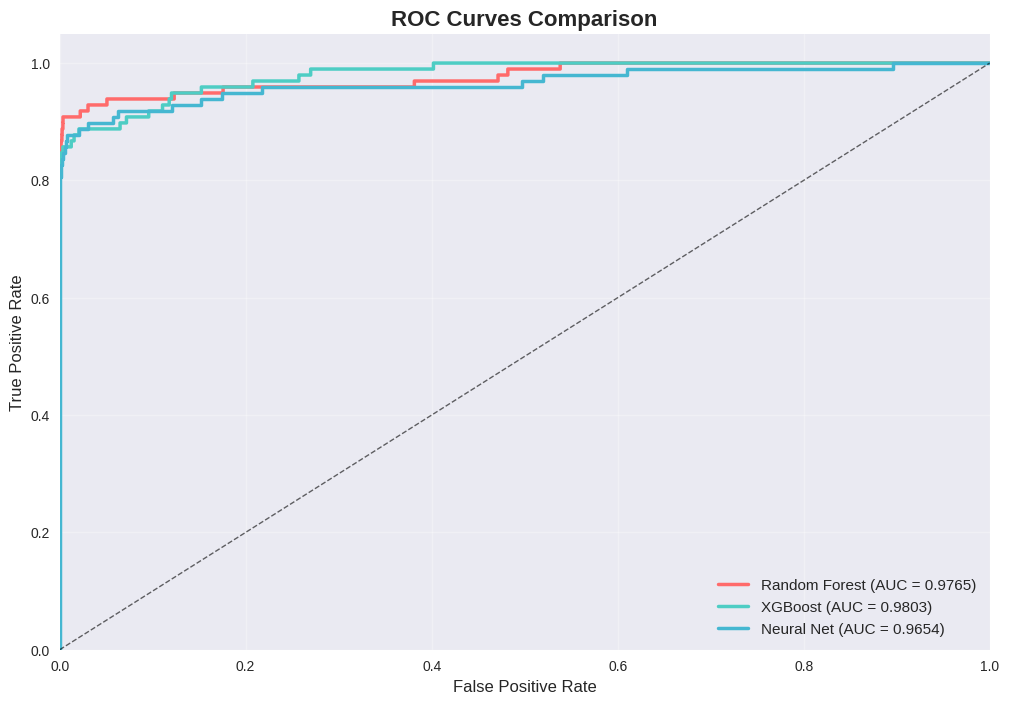

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:18:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


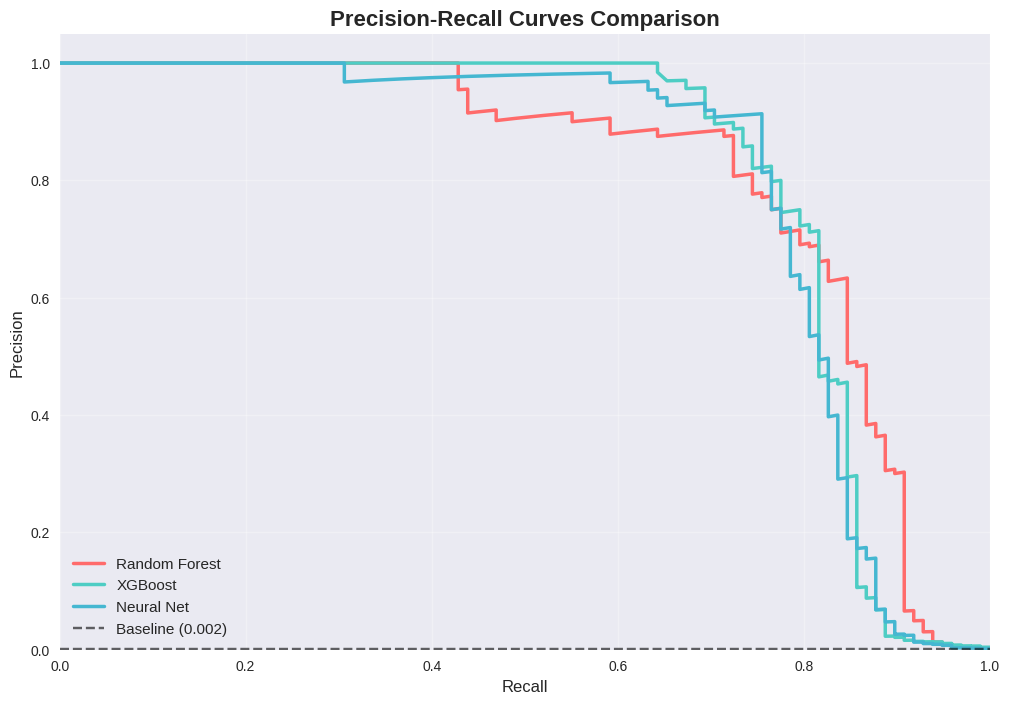

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:19:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


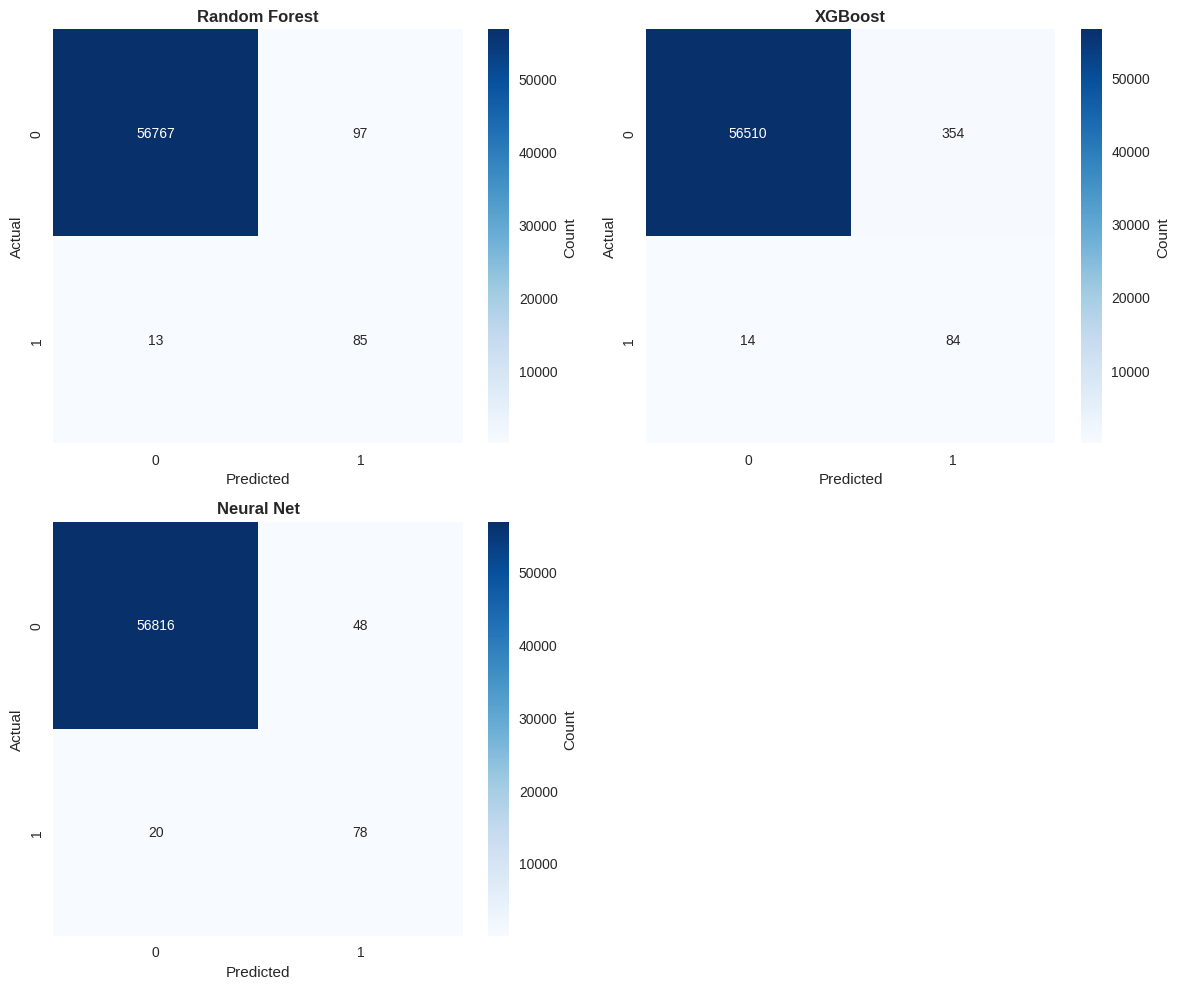

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:19:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


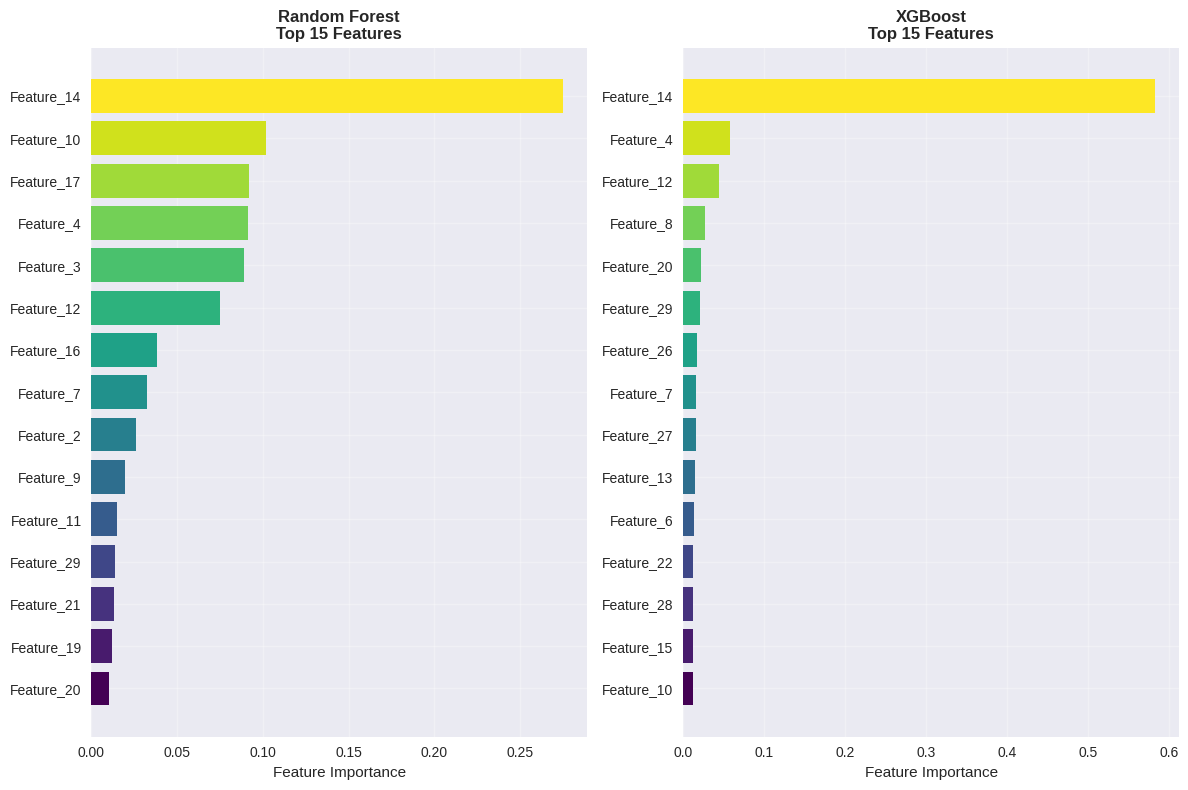

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:20:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


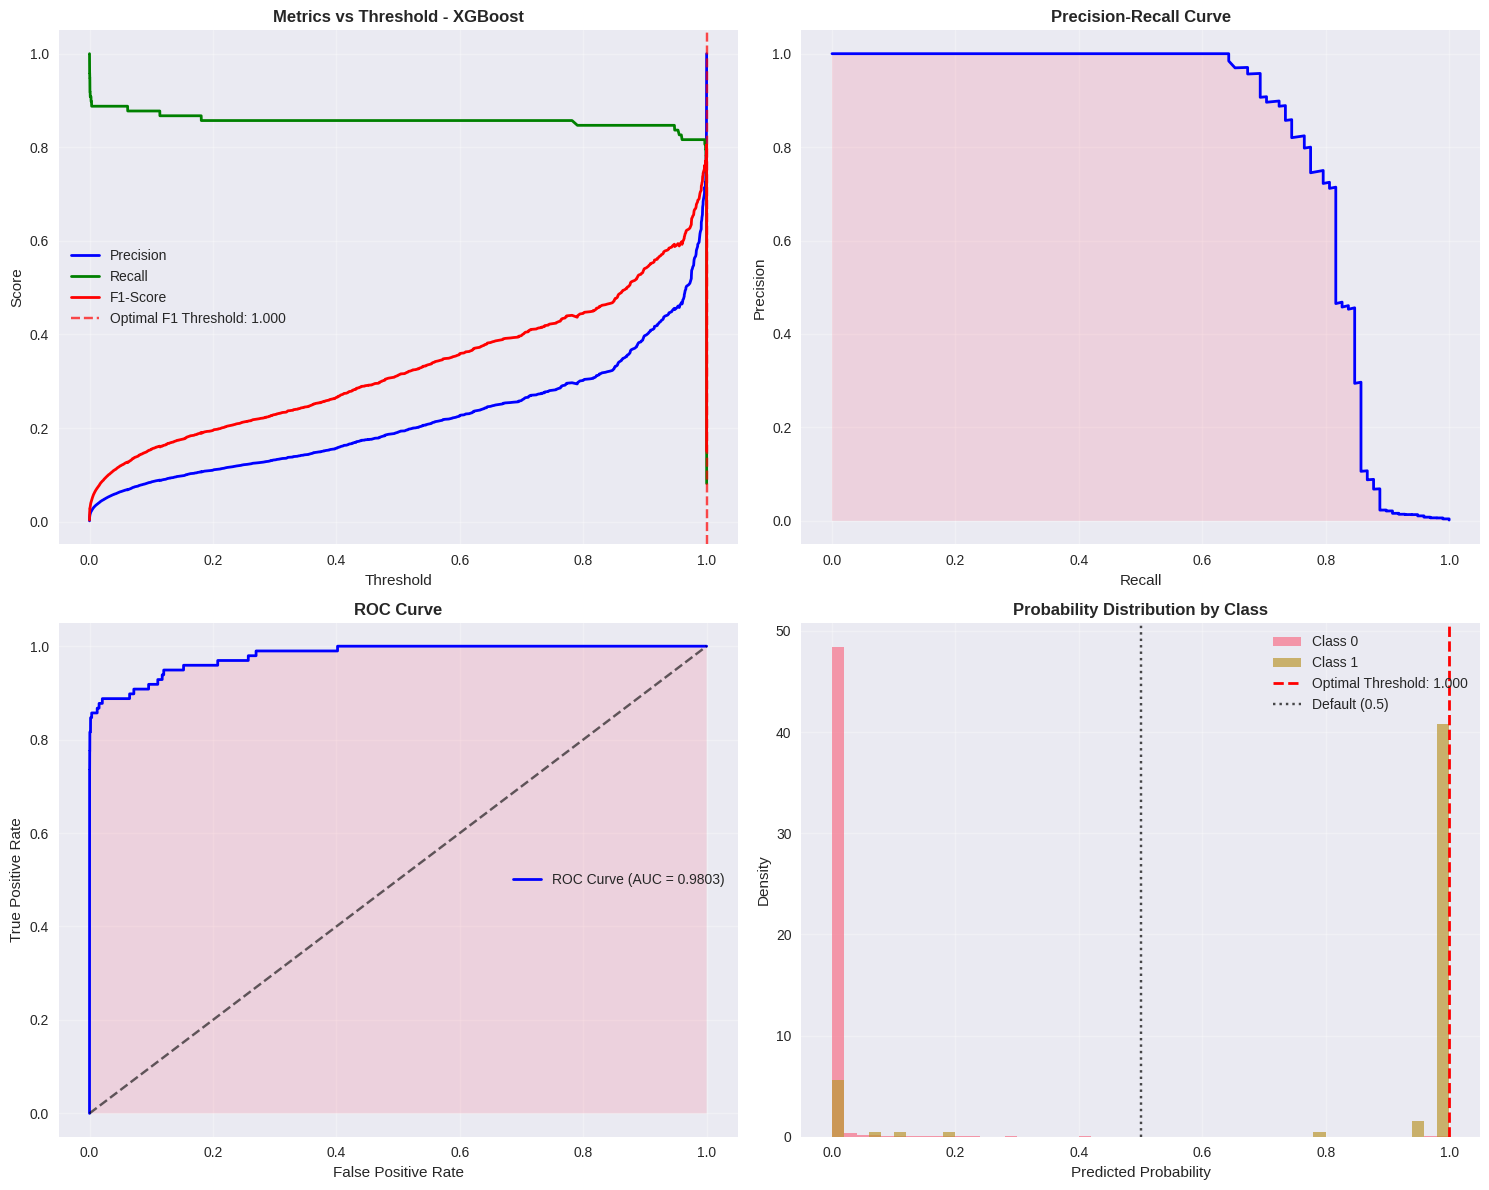

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (roc_curve, precision_recall_curve, confusion_matrix,
                           roc_auc_score, classification_report)
from sklearn.calibration import calibration_curve
import pandas as pd

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_cv_results(cv_results):
    """Plot cross-validation results comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Box plot of CV scores
    cv_data = []
    model_names = []
    for name, scores in cv_results.items():
        cv_data.extend(scores)
        model_names.extend([name] * len(scores))

    cv_df = pd.DataFrame({'Model': model_names, 'ROC_AUC': cv_data})

    sns.boxplot(data=cv_df, x='Model', y='ROC_AUC', ax=ax1)
    ax1.set_title('Cross-Validation ROC-AUC Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('ROC-AUC Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Bar plot of mean CV scores with error bars
    means = [scores.mean() for scores in cv_results.values()]
    stds = [scores.std() for scores in cv_results.values()]
    names = list(cv_results.keys())

    bars = ax2.bar(names, means, yerr=stds, capsize=5, alpha=0.7,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_title('Mean Cross-Validation Performance', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Mean ROC-AUC ± Std')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.005,
                f'{mean:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(models, X_test, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(12, 8))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

    for i, (name, model) in enumerate(models.items()):
        # Train pipeline
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)

        # Get probabilities
        y_probs = pipeline.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc_score = roc_auc_score(y_test, y_probs)

        # Plot
        plt.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2.5,
                label=f'{name} (AUC = {auc_score:.4f})')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=1)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_precision_recall_curves(models, X_test, y_test):
    """Plot Precision-Recall curves for all models"""
    plt.figure(figsize=(12, 8))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

    for i, (name, model) in enumerate(models.items()):
        # Train pipeline
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)

        # Get probabilities
        y_probs = pipeline.predict_proba(X_test)[:, 1]

        # Calculate PR curve
        precision, recall, _ = precision_recall_curve(y_test, y_probs)

        # Plot
        plt.plot(recall, precision, color=colors[i % len(colors)], linewidth=2.5,
                label=f'{name}')

    # Add baseline (proportion of positive class)
    baseline = y_test.mean()
    plt.axhline(y=baseline, color='k', linestyle='--', alpha=0.6,
                label=f'Baseline ({baseline:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontsize=16, fontweight='bold')
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_confusion_matrices(models, X_test, y_test, threshold=0.5):
    """Plot confusion matrices for all models"""
    n_models = len(models)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, (name, model) in enumerate(models.items()):
        if i >= 4:  # Limit to 4 models for clean display
            break

        # Train pipeline
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)

        # Get predictions
        y_probs = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= threshold).astype(int)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   cbar_kws={'label': 'Count'})
        axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Hide empty subplots
    for j in range(i+1, 4):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_feature_importance(models, X_train, y_train, feature_names=None, top_n=15):
    """Plot feature importance for tree-based models"""
    tree_models = {}

    # Filter tree-based models
    for name, model in models.items():
        if hasattr(model, 'feature_importances_') or 'Forest' in str(type(model)) or 'XGB' in str(type(model)):
            tree_models[name] = model

    if not tree_models:
        print("No tree-based models found for feature importance plot")
        return

    n_models = len(tree_models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))

    if n_models == 1:
        axes = [axes]

    for i, (name, model) in enumerate(tree_models.items()):
        # Train model without SMOTE for feature importance
        model.fit(X_train, y_train)

        # Get feature importance
        importance = model.feature_importances_

        if feature_names is None:
            feature_names = [f'Feature_{j}' for j in range(len(importance))]

        # Sort by importance
        indices = np.argsort(importance)[::-1][:top_n]

        # Plot
        axes[i].barh(range(top_n), importance[indices][::-1],
                    color=plt.cm.viridis(np.linspace(0, 1, top_n)))
        axes[i].set_yticks(range(top_n))
        axes[i].set_yticklabels([feature_names[idx] for idx in indices[::-1]])
        axes[i].set_xlabel('Feature Importance')
        axes[i].set_title(f'{name}\nTop {top_n} Features', fontweight='bold')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_threshold_analysis(best_model, X_train, y_train, X_test, y_test, model_name):
    """Plot threshold analysis for the best model"""
    # Train model
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', best_model)
    ])
    pipeline.fit(X_train, y_train)
    y_probs = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Precision, Recall, F1 vs Threshold
    ax1.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall', linewidth=2)
    ax1.plot(thresholds, f1_scores[:-1], 'r-', label='F1-Score', linewidth=2)

    # Mark optimal F1 threshold
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]
    ax1.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7,
                label=f'Optimal F1 Threshold: {optimal_threshold:.3f}')

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.set_title(f'Metrics vs Threshold - {model_name}', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Precision-Recall Curve
    ax2.plot(recall, precision, 'b-', linewidth=2)
    ax2.fill_between(recall, precision, alpha=0.2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Plot 3: ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)
    ax3.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    ax3.fill_between(fpr, tpr, alpha=0.2)
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Threshold Distribution
    ax4.hist(y_probs[y_test == 0], bins=50, alpha=0.7, label='Class 0', density=True)
    ax4.hist(y_probs[y_test == 1], bins=50, alpha=0.7, label='Class 1', density=True)
    ax4.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Optimal Threshold: {optimal_threshold:.3f}')
    ax4.axvline(x=0.5, color='black', linestyle=':', alpha=0.7, label='Default (0.5)')
    ax4.set_xlabel('Predicted Probability')
    ax4.set_ylabel('Density')
    ax4.set_title('Probability Distribution by Class', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return optimal_threshold

def plot_performance_dashboard(results_df):
    """Create a comprehensive performance dashboard"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: ROC-AUC Comparison
    models = results_df['Model']
    cv_auc = results_df['CV_ROC_AUC']
    test_auc = results_df['Test_ROC_AUC']

    x = np.arange(len(models))
    width = 0.35

    bars1 = ax1.bar(x - width/2, cv_auc, width, label='CV ROC-AUC', alpha=0.8)
    bars2 = ax1.bar(x + width/2, test_auc, width, label='Test ROC-AUC', alpha=0.8)

    ax1.set_xlabel('Models')
    ax1.set_ylabel('ROC-AUC Score')
    ax1.set_title('Cross-Validation vs Test ROC-AUC', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # Plot 2: Precision vs Recall
    precision = results_df['Precision']
    recall = results_df['Recall']

    scatter = ax2.scatter(recall, precision, s=200, alpha=0.7,
                         c=range(len(models)), cmap='viridis')

    for i, model in enumerate(models):
        ax2.annotate(model, (recall.iloc[i], precision.iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision vs Recall Trade-off', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Plot 3: F1-Score Comparison
    f1_scores = results_df['F1_Score']
    bars3 = ax3.bar(models, f1_scores, color=plt.cm.plasma(np.linspace(0, 1, len(models))))
    ax3.set_xlabel('Models')
    ax3.set_ylabel('F1-Score')
    ax3.set_title('F1-Score Comparison', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars3, f1_scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 4: Threshold Analysis
    thresholds = results_df['Best_Threshold']
    bars4 = ax4.bar(models, thresholds, color=plt.cm.coolwarm(np.linspace(0, 1, len(models))))
    ax4.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Default (0.5)')
    ax4.set_xlabel('Models')
    ax4.set_ylabel('Optimal Threshold')
    ax4.set_title('Optimal Thresholds for F1-Score', fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add value labels
    for bar, thresh in zip(bars4, thresholds):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{thresh:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_cv_results(cv_results)
plot_roc_curves(models, X_test, y_test)
plot_precision_recall_curves(models, X_test, y_test)
plot_confusion_matrices(models, X_test, y_test, threshold=0.5)
plot_feature_importance(models, X_train, y_train)
best_model = models["XGBoost"]  # Use your best model
optimal_thresh = plot_threshold_analysis(best_model, X_train, y_train, X_test, y_test, "XGBoost")